# Title of Your Group Project

This Python notebook serves as a template for your group project on Experiment 2: *Task switching with letters and numbers* for the course 'Modeling in Cognitive Science'.
This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*


For more information, you can check the task's GitHub repository:
[task switching with letter and numbers](https://github.com/snamazova/task_switch)


## Data Loading


In [1]:
# #Optional: Checking specs to see where to run the code
# from utils import print_cpu_specs
# print_cpu_specs()

In [2]:
import json
import os
import pandas as pd

from data_cleaning import clean_data

In [3]:
COLAB = False
if os.getenv("COLAB_RELEASE_TAG"):
   print("Running in Colab")
   !pip install ipywidgets
   !pip install git+https://github.com/lnccbrown/HSSM.git
   from google.colab import files
   import hssm
   import hssm.plotting
   COLAB = True
   
else:
   print("NOT in Colab")

NOT in Colab


In [4]:
# upload the file manually
file_name = "data/example.json"
if COLAB:
    uploaded = files.upload()
    # get the filename from the uploaded dictionary
    file_name = list(uploaded.keys())[0]

# open and load the JSON file
with open(file_name, "r") as f:
    data = json.load(f)

# convert JSON to a DataFrame
df_raw = pd.json_normalize(data)

# display the DataFrame columns to analyze it
print(df_raw.columns)
df_raw.head(1)

Index(['rt', 'stimulus', 'response', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'bean_trial_duration',
       'bean_duration', 'bean_stimulus', 'bean_choices', 'bean_correct_key',
       'bean_type', 'bean_text', 'bean_color', 'bean_correct',
       'bean_num_correct', 'bean_accuracy', 'bean_task_type'],
      dtype='object')


rt                                           stimulus response  \
0  648.0  <div style='color:white'>Welcome to our task-s...            

               trial_type  trial_index  time_elapsed internal_node_id  \
0  html-keyboard-response            0           649      0.0-0.0-0.0   

   bean_trial_duration  bean_duration  \
0                  NaN            NaN   

                                       bean_stimulus bean_choices  \
0  <div style='color:white'>Welcome to our task-s...          [ ]   

  bean_correct_key                    bean_type  \
0                   jsPsychHtmlKeyboardResponse   

                                           bean_text bean_color  bean_correct  \
0  Welcome to our task-switching experiment.What ...      white         False   

   bean_num_correct  bean_accuracy bean_task_type  
0               NaN            NaN            NaN

### DataFrame Structure Overview

The DataFrame contains multiple columns representing various aspects of a **task-switching experiment**. Below is a breakdown of the key columns:  

## 1. General Trial Information  
- **`trial_index`**: The index of the current trial in the experiment(feedback is also considered as trial)  
- **`trial_type`**: The type of trial, indicating how the response was made (e.g., via keyboard or mouse click).  
- **`time_elapsed`**: The total time elapsed (in milliseconds) since the start of the experiment.  
- **`internal_node_id`**: An internal identifier for the trial structure.  

## 2. Response and Stimulus Data  
- **`stimulus`**: The presented stimulus for the trial.  
- **`response`**: The participant’s response/input during the trial.  
- **`rt`**: The reaction time (in milliseconds) taken to respond.  

## 3. Task-Specific Information (Task-Switching Task)   
- **`bean_trial_duration`**: The duration of the bean trial  
- **`bean_duration`**: The time the bean stimulus was displayed (with a maximum duration of 2000ms; if no response is given within this time, the trial automatically switches to the next one and is considered incorrect).
- **`bean_stimulus`**: The presented stimulus for the trial.  
- **`bean_choices`**: The available choice options in the trial.  
- **`bean_correct_key`**: The correct key (button press) for the task.  
- **`bean_type`**: The category of the bean stimulus, determined by how the participant responded (e.g., clicking or pressing a key)
- **`bean_text`**: A text representation of the bean (stimulus is inside `div` tag).  
- **`bean_color`**: The color of the bean
- **`bean_correct`**: A boolean or categorical value indicating whether the response was correct.  
- **`bean_num_correct`**: The number of correct responses across trials.  
- **`bean_accuracy`**: The participant's accuracy in the task, typically computed as the proportion of correct responses.  
- **`bean_task_type`**: The type of task being performed within the task-switching paradigm(letter or number task)


In [5]:
data_cleaned = clean_data(df_raw)
# data_cleaned.head(5)
data_cleaned.tail(5)

 data cleaning done. number of valid trails: 93


task trial_type  response  accuracy  choice_adjusted     rt  switch  \
88  letter     switch         1  0.887640                0  2.270       1   
89  number     switch         1  0.888889                1  2.280       1   
90  letter     switch         1  0.890110                0  1.741       1   
91  letter     repeat         1  0.891304                0  0.857       0   
92  letter     repeat         1  0.892473                0  0.921       0   

   participant_response correct_key key_choices stimuli  
88                    n           n      [b, n]      E2  
89                    b           b      [b, n]      K9  
90                    n           n      [b, n]      A2  
91                    b           b      [b, n]      G5  
92                    n           n      [b, n]      U6

In [6]:
# save to csv file, with a unique timeestamp
import datetime
timestamp = datetime.datetime.now().strftime("%m%d_%H%M")
# create folder data_cleaned if it does not exist
directory = "data_cleaned"
os.makedirs(directory, exist_ok=True)
filename = f"data_cleaned_{timestamp}.csv"
data_cleaned.to_csv(os.path.join(directory, filename), index=False)

# download the saved csv
if COLAB:
    files.download(filename)

## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


### Model Formulation

### Insight into the latent varaibles in a simulation on one trial

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from model import simulate_dynamics, plot_trajectory

In [ ]:
from ipywidgets import interact, widgets

def interactive_plot_trial(g, alpha, gamma, x1_0, x2_0, P_0, feedback):
    I1 = 1        # Input to task 1
    I2 = 0        # Input to task 2
    sigma = 0.4    # noise
    T = 8         # Simulation time

    x_0 = [x1_0, x2_0, P_0]

    input = [I1, I2]
    np.random.seed(0)

    # Run the simulationnear
    ts, x1, x2, P  = simulate_dynamics(T, x_0, g, alpha, gamma, input, feedback, sigma, num_sample_points=100)

    # Plot the trajectory
    plt.close('all')
    plot_trajectory(T, ts, x1, x2, P, input=[np.where(np.array(input) != 1)[0][0]], feedback=[feedback])

# Create interactive sliders
feedback_slider = widgets.IntSlider(value=-1, min=-1, max=1, step=1, description="Feedback:")
g_slider = widgets.FloatSlider(value=1.5, min=0.0, max=10.0, step=0.5, description="Gain (g):")
alpha_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1, step=0.1, description="alpha:")
gamma_slider = widgets.FloatSlider(value=0.3, min=-1.0, max=1.0, step=0.1, description="gamma:")
x1_0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description="x1_0:")
x2_0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description="x2_0:")
P_0_silder = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description="P_0:")

# Use the interact function to create the interactive plot
interact(interactive_plot_trial, g=g_slider, alpha=alpha_slider, gamma=gamma_slider ,x1_0=x1_0_slider, x2_0=x2_0_slider, P_0=P_0_silder, feedback=feedback_slider);
plt.close('all')

interactive(children=(FloatSlider(value=1.5, description='Gain (g):', max=10.0, step=0.5), FloatSlider(value=0…

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. The model plots should depict key features of the behavioral data, convincing yourself that the models are suitable to capture the data. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [9]:
from model_simulation import simulate_experiment, generate_experiment_trials
from analysis import calculate_accuracy_per_condition, plot_accuracy_per_condition


### Insight into the Dynamics of the two Models across multiple trails

In [10]:
from ipywidgets import interact, widgets
def interactive_plot_experiment(g, alpha, gamma, x1_0, x2_0, P_0, experiment_trials):
    # simulating a small sample of trials to get an insight into the dynamics for both models
    seed = 40
    T = 2
    sigma = 0.2
    c = 0
    x_0 = [x1_0, x2_0, P_0]
    # Base Model
    np.random.seed(seed)
    _ = simulate_experiment(num_trials, T, x_0, g, c, 0, 0, sigma, bool_plot_trajectory = True, task_sequence = experiment_trials)

    # Perseverence Model
    np.random.seed(seed)
    _ = simulate_experiment(num_trials, T, x_0, g, c, alpha, gamma, sigma, bool_plot_trajectory = True, task_sequence = experiment_trials)


num_trials = 20
experiment_trials = generate_experiment_trials(num_trials)

# Create interactive sliders
g_slider = widgets.FloatSlider(value=1.5, min=0.0, max=10.0, step=0.5, description="Gain (g):")
alpha_slider = widgets.FloatSlider(value=0.1, min=0.0, max=1, step=0.1, description="alpha:")
gamma_slider = widgets.FloatSlider(value=0.3, min=-1.0, max=1.0, step=0.1, description="gamma:")
x1_0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description="x1_0:")
x2_0_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description="x2_0:")
P_0_silder = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.1, description="P_0:")

# Use the interact function to create the interactive plot
interact(interactive_plot_experiment, g=g_slider, alpha=alpha_slider, gamma=gamma_slider ,x1_0=x1_0_slider, x2_0=x2_0_slider, P_0=P_0_silder, 
                                        experiment_trials=widgets.fixed(experiment_trials));

interactive(children=(FloatSlider(value=1.5, description='Gain (g):', max=10.0, step=0.5), FloatSlider(value=0…

### Surrogate Data from the two Models



In [11]:
# simulating a small sample of trials to get an insight into the dynamics for both models
seed = 40
num_trials = 100
T = 2

sigma = 0.2
g = 2
c = 0.0

alpha = 0.1
gamma = 0.3

x_0 = [0.5, 0.5, 0]

experiment_trials = generate_experiment_trials(num_trials)
# Base Model
np.random.seed(seed)
data_Base = simulate_experiment(num_trials, T, x_0, g, c, 0, 0, sigma, bool_plot_trajectory = False, task_sequence = experiment_trials)

# Perseverence Model
np.random.seed(seed)
data_P = simulate_experiment(num_trials, T, x_0, g, c, alpha, gamma, sigma, bool_plot_trajectory = False, task_sequence = experiment_trials)

In [12]:
# printing samples of the surrogate data
print("Surregate Data from Base Model:")
display(data_Base.head(10))

print("Surregate Data from Perserverance Model:")
display(data_P.head(10))

print('accuracy base: ', data_Base['accuracy'].iloc[-1])
print('accuracy perseverance: ', data_P['accuracy'].iloc[-1])

Surregate Data from Base Model:


task trial_type  response  accuracy  choice_adjusted  activity_n1  \
0  letter     repeat         1  1.000000                0     0.827429   
1  letter     repeat         1  1.000000                0     0.825307   
2  letter     repeat         1  1.000000                0     0.842223   
3  number     switch         1  1.000000                1     0.342840   
4  number     repeat         1  1.000000                1     0.195639   
5  letter     switch         1  1.000000                0     0.668937   
6  letter     repeat         1  1.000000                0     0.812174   
7  letter     repeat         0  0.875000                1     0.824543   
8  number     switch         1  0.888889                1     0.347281   
9  number     repeat         1  0.900000                1     0.213433   

   activity_n2 correct_responses  trial_index  
0     0.183690            [1, 0]            1  
1     0.189264            [1, 0]            2  
2     0.177619            [1, 0]            3  
3     0.654977            [0, 1]            4  
4     0.787816            [0, 1]            5  
5     0.327669            [1, 0]            6  
6     0.197058            [1, 0]            7  
7     0.161090            [1, 0]            8  
8     0.655008            [0, 1]            9  
9     0.799775            [0, 1]           10

Surregate Data from Perserverance Model:


task trial_type  response  accuracy  choice_adjusted  activity_n1  \
0  letter     repeat         1  1.000000                0     0.884639   
1  letter     repeat         1  1.000000                0     0.912087   
2  letter     repeat         1  1.000000                0     0.922583   
3  number     switch         1  1.000000                1     0.512044   
4  number     repeat         1  1.000000                1     0.235342   
5  letter     switch         1  1.000000                0     0.614084   
6  letter     repeat         1  1.000000                0     0.820325   
7  letter     repeat         1  1.000000                0     0.897873   
8  number     switch         0  0.888889                0     0.493054   
9  number     repeat         1  0.900000                1     0.284814   

   activity_n2 correct_responses  trial_index  
0     0.123334            [1, 0]            1  
1     0.087065            [1, 0]            2  
2     0.082432            [1, 0]            3  
3     0.494769            [0, 1]            4  
4     0.763900            [0, 1]            5  
5     0.387378            [1, 0]            6  
6     0.168396            [1, 0]            7  
7     0.097367            [1, 0]            8  
8     0.498489            [0, 1]            9  
9     0.715512            [0, 1]           10

accuracy base:  0.8383838383838383
accuracy perseverance:  0.7777777777777778


### Behavioral insight (plots) of the two models

{'average_accuracy_switch': 0.813953488372093, 'average_accuracy_repeat': 0.8571428571428571} (base model)
{'average_accuracy_switch': 0.6511627906976745, 'average_accuracy_repeat': 0.875} (perseverance model)


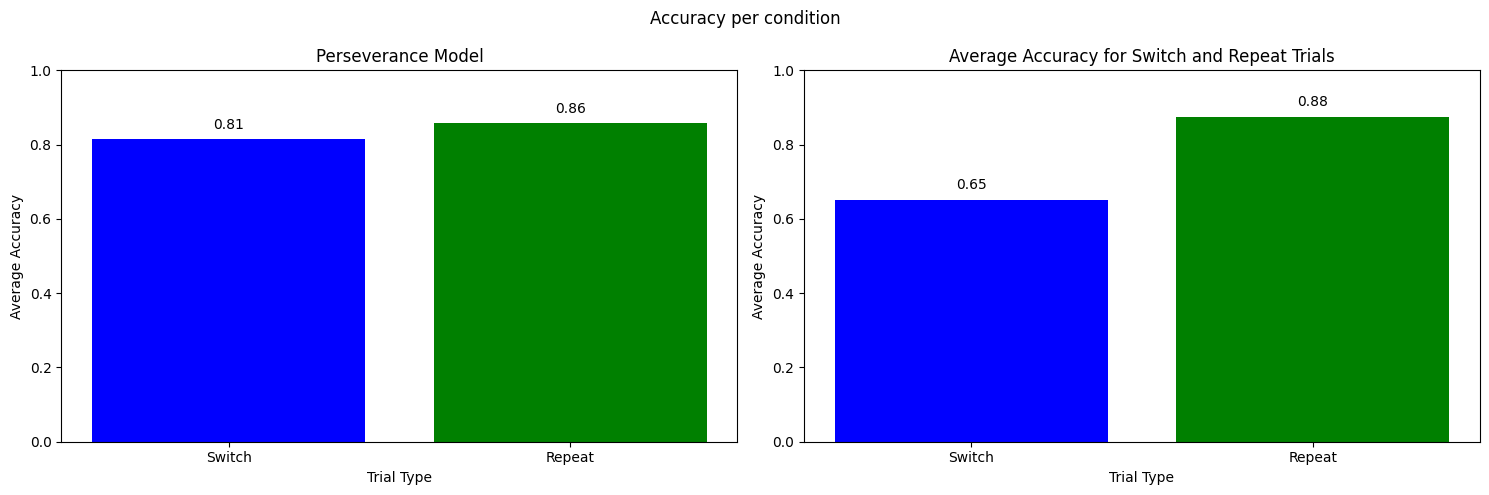

In [13]:
acc_per_condition_baase = calculate_accuracy_per_condition(data_Base)
acc_per_condition_perseverance = calculate_accuracy_per_condition(data_P)
print(acc_per_condition_baase, '(base model)')
print(acc_per_condition_perseverance, '(perseverance model)')

# Plotting the accuracy per condition of the base and perseverance model
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.ravel()
fig.suptitle('Accuracy per condition')
plot_accuracy_per_condition(data_Base, ax=axs[0])
axs[0].set_title('Base Model')

plot_accuracy_per_condition(data_P, ax=axs[1])
axs[0].set_title('Perseverance Model')

plt.tight_layout()
plt.show()

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [14]:
from parameter_fitting import param_fit_grid_search, param_fit_grid_search_parallel, plot_heatmap
from model_simulation import simulate_experiment
from analysis import calculate_accuracy_per_condition, plot_accuracy_per_condition

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Fitting the two models to either surregate or participant data

In [15]:
# Parameter Fitting
seed = 40
np.random.seed(seed)
# search space over parameters T and g (sigma and c are assumed to be known)
num_samples = 5
min_g, max_g = 0, 5
min_c, max_c = -2, 2
min_alpha, max_alpha = 0, 1
min_gamma, max_gamma = -1, 1

g_values = np.linspace(min_g, max_g, num_samples)
c_values = np.linspace(min_c, max_c, num_samples)
alpha_values = np.linspace(min_alpha, max_alpha, num_samples)
gamma_values = np.linspace(min_gamma, max_gamma, num_samples)

# experiment parameters
num_trials = 100

# setting model parameters
T = 2
sigma = 0.2

true_g = 3
true_c = -0.5
true_alpha = 0.1
true_gamma = 0.4

x_0 = [0.5, 0.5, 0]

plt.rcParams.update({'font.size': 18, 'font.family': "sans-serif"}) # 'font.weight': 'bold'

experiment_trials = generate_experiment_trials(num_trials)
# obtain surrogate data by simulating the model with the set parameters
df_base = simulate_experiment(num_trials, T, x_0, true_g, true_c, 0, 0, sigma, task_sequence = experiment_trials)
df_P = simulate_experiment(num_trials, T, x_0, true_g, true_c, true_alpha, true_gamma, sigma, task_sequence = experiment_trials)

Run the cell below to fit on a participant data instead of the surrogate data generated above.

In [16]:
# fit to participant
df_base = data_cleaned.copy()
df_P = data_cleaned.copy()

In [17]:
# base model: run parameter fitting and get the LL landscape values and the best fitted parameters
best_g_base, best_c_base, best_alpha_base, best_gamma_base, best_LL_base, LL_matrix_base = param_fit_grid_search_parallel(df_base, T, x_0, g_values, c_values, np.zeros(1), np.zeros(1), sigma)

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
# perseverence model: run parameter fitting and get the LL landscape values and the best fitted parameters
best_g_P, best_c_P, best_alpha_P, best_gamma_P, best_LL_P, LL_matrix_P = param_fit_grid_search_parallel(df_P, T, x_0, g_values, c_values, alpha_values, gamma_values, sigma)

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

In [19]:
# print search space
print("g_values:", g_values)
print("c_values:", c_values)
print("alpha_values:", alpha_values)
print("gamma_values:", gamma_values)
print("true_g:", true_g)
print("true_c:", true_c)
print("true_alpha:", true_alpha)
print("true_gamma:", true_gamma)

g_values: [0.   1.25 2.5  3.75 5.  ]
c_values: [-2. -1.  0.  1.  2.]
alpha_values: [0.   0.25 0.5  0.75 1.  ]
gamma_values: [-1.  -0.5  0.   0.5  1. ]
true_g: 3
true_c: -0.5
true_alpha: 0.1
true_gamma: 0.4


best_LL_base: -32.07641756783698
best_g_base: 5.0
best_c_base: 0.0
best_alpha_base: 0.0
best_gamma_base: 0.0


<Axes: title={'center': 'LL landscape (alpha=0, gamma=0)'}, xlabel='c', ylabel='g'>

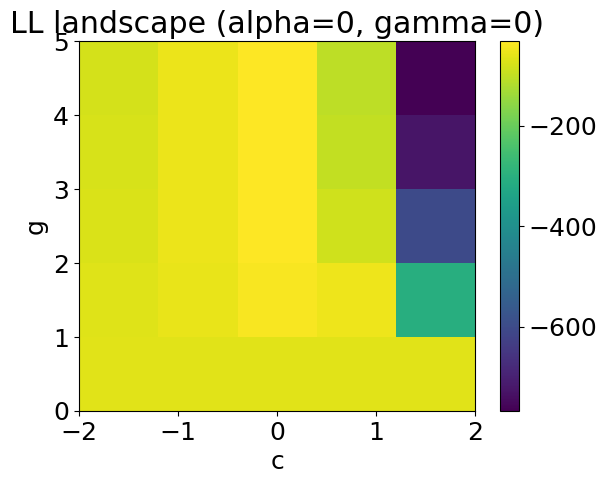

In [20]:
print("best_LL_base:", best_LL_base)
print("best_g_base:", best_g_base)
print("best_c_base:", best_c_base)
print("best_alpha_base:", best_alpha_base)
print("best_gamma_base:", best_gamma_base)

plot_heatmap(LL_matrix_base[:,:,0,0], g_values, c_values, 'g', 'c', f'LL landscape (alpha={0}, gamma={0})')

best_LL_P: -31.614125716904
best_g_P: 3.75
best_c_P: 0.0
best_alpha_P: 0.0
best_gamma_P: -0.5


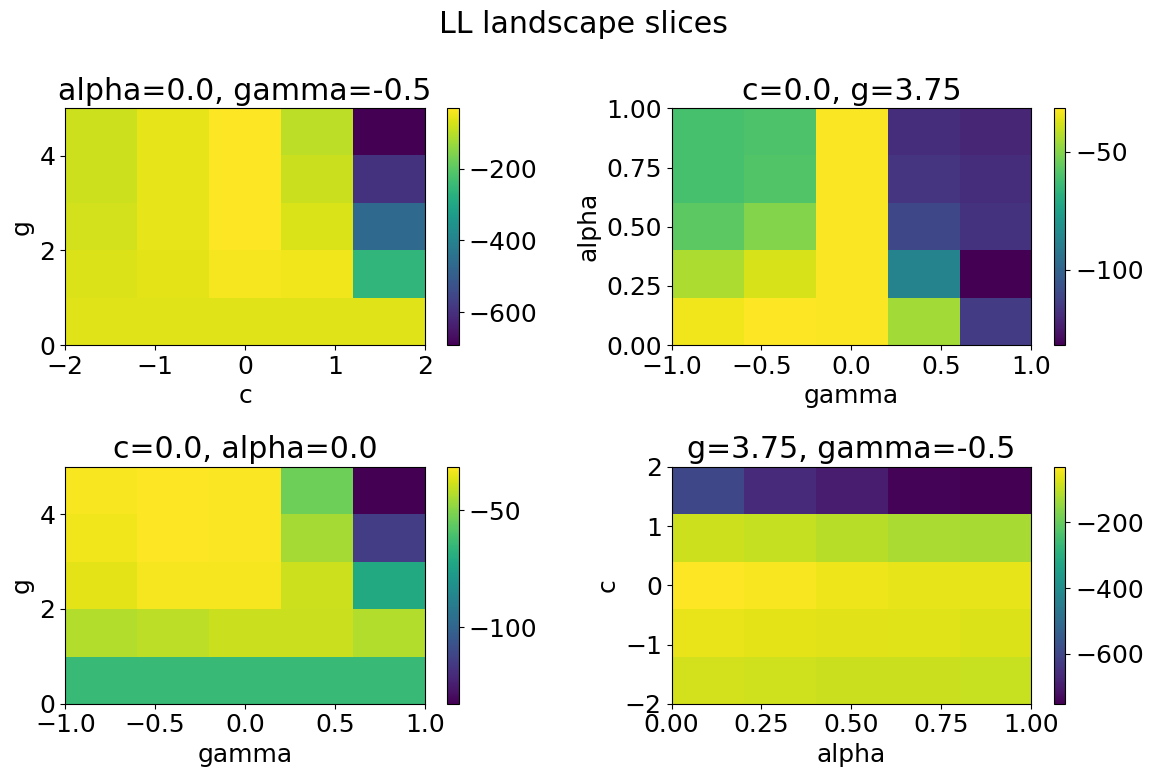

In [21]:
print("best_LL_P:", best_LL_P)
print("best_g_P:", best_g_P)
print("best_c_P:", best_c_P)
print("best_alpha_P:", best_alpha_P)
print("best_gamma_P:", best_gamma_P)

# fix two parameters around the best values and plot the other 
g_idx_fixed = np.argmin(np.abs(g_values - best_g_P)) 
c_idx_fixed = np.argmin(np.abs(c_values - best_c_P))  
alpha_idx_fixed = np.argmin(np.abs(alpha_values - best_alpha_P))  
gamma_idx_fixed = np.argmin(np.abs(gamma_values - best_gamma_P))  

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('LL landscape slices')
axs = axs.ravel()
# 2D slice for c and g
LL_slice_g_c = LL_matrix_P[:, :, alpha_idx_fixed, gamma_idx_fixed]
plot_heatmap(LL_slice_g_c, g_values, c_values, 'g', 'c', f'alpha={round(best_alpha_P,2)}, gamma={round(best_gamma_P,2)}', ax=axs[0])

# 2D slice for alpha and gamma
LL_slice_alpha_gamma = LL_matrix_P[g_idx_fixed, c_idx_fixed, :, :]
plot_heatmap(LL_slice_alpha_gamma, alpha_values, gamma_values, 'alpha', 'gamma', f'c={round(best_c_P, 2)}, g={round(best_g_P, 2)}', ax=axs[1])

# 2D slice for g and gamma
LL_slice_g_gamma = LL_matrix_P[:, c_idx_fixed, alpha_idx_fixed, :]
plot_heatmap(LL_slice_g_gamma, g_values, gamma_values, 'g', 'gamma', f'c={round(best_c_P, 2)}, alpha={round(best_alpha_P, 2)}', ax=axs[2])

# 2D slice for c and alpha
LL_slice_c_alpha = LL_matrix_P[g_idx_fixed, :, :, gamma_idx_fixed]
plot_heatmap(LL_slice_c_alpha, c_values, alpha_values, 'c', 'alpha', f'g={round(best_g_P, 2)}, gamma={round(best_gamma_P, 2)}', ax=axs[3])

plt.tight_layout()
plt.show()

#### brief inspection of the fitted models, as a sanity check

Ploting first 20 trials:


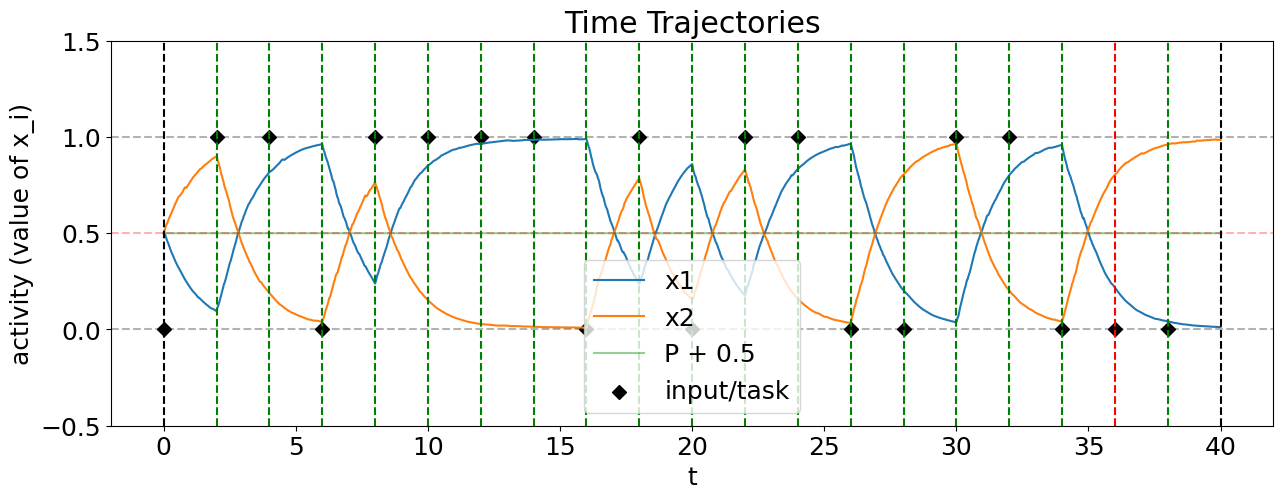

Ploting first 20 trials:


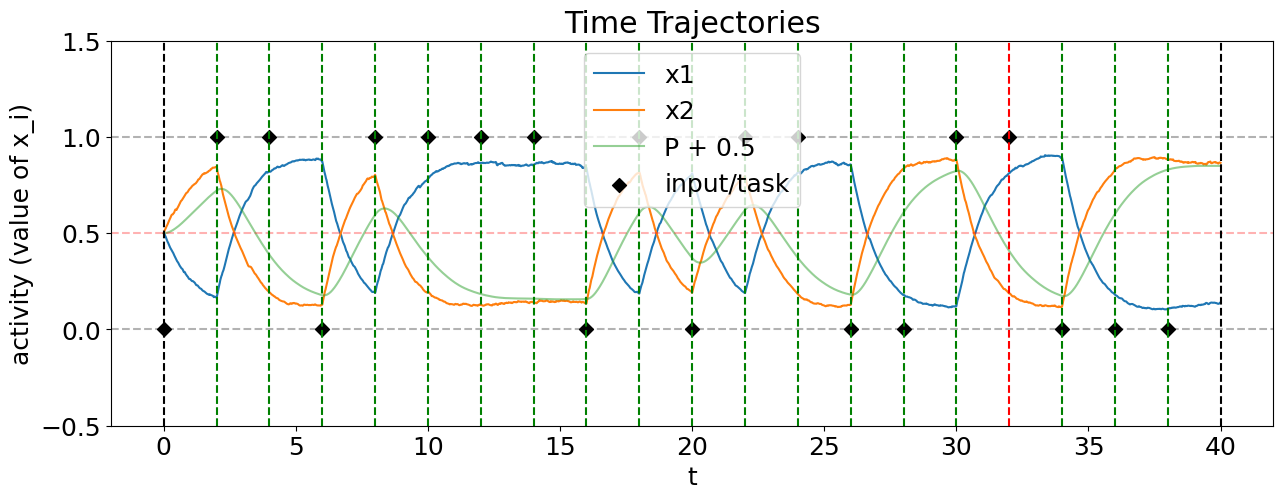

In [22]:
# simulating a small sample of trials to get an insight into the dynamics for both models
seed = 40
# num_trials = 100
# T = 2
# sigma = 0.2
# x_0 = [0.5, 0.5, 0]

experiment_trials = generate_experiment_trials(num_trials)
# Base Model
np.random.seed(seed)
data_Base = simulate_experiment(num_trials, T, x_0, best_g_base, best_c_base, 0, 0, sigma, bool_plot_trajectory = True, task_sequence = experiment_trials)

# Perseverence Model
np.random.seed(seed)
data_P = simulate_experiment(num_trials, T, x_0, best_g_P, best_c_P, best_alpha_P, best_gamma_P, sigma, bool_plot_trajectory = True, task_sequence = experiment_trials)

accuracy base:  0.9393939393939394
accuracy perserverance:  0.9292929292929293
accuracy participant:  0.8924731182795699
{'average_accuracy_switch': 0.8979591836734694, 'average_accuracy_repeat': 0.98}  (base)
{'average_accuracy_switch': 0.8979591836734694, 'average_accuracy_repeat': 0.96}  (P)
{'average_accuracy_switch': 0.8780487804878049, 'average_accuracy_repeat': 0.9038461538461539}  (participant)


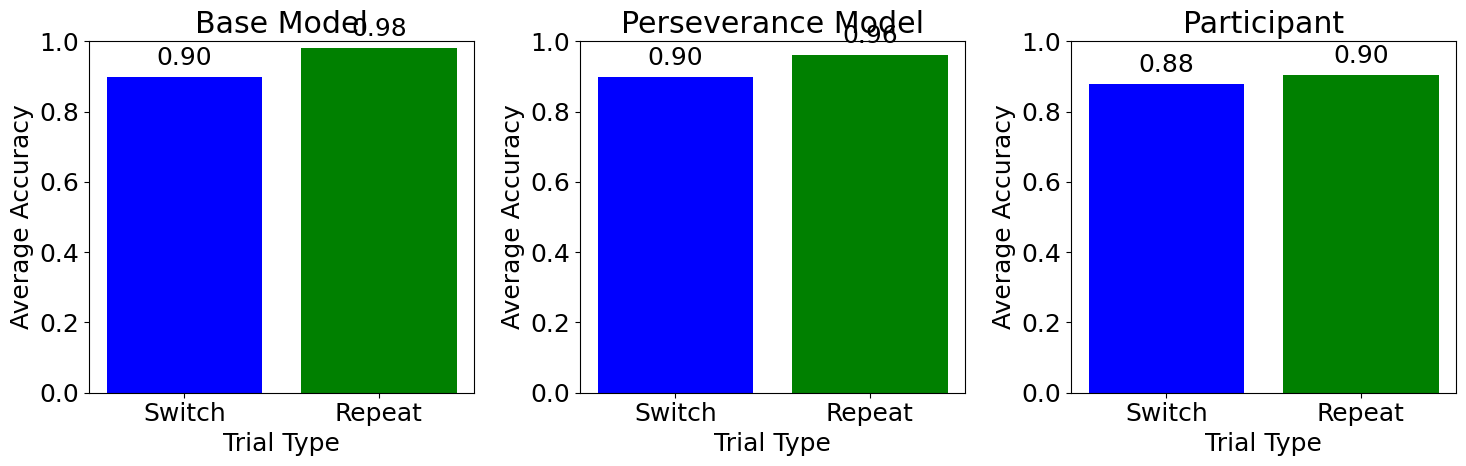

In [23]:
# plot accuary over trails for both models
print('accuracy base: ', data_Base.iloc[-1]['accuracy'])
print('accuracy perserverance: ', data_P.iloc[-1]['accuracy'])
print('accuracy participant: ', data_cleaned.iloc[-1]['accuracy'])

compare_base = calculate_accuracy_per_condition(data_Base)
compare_P = calculate_accuracy_per_condition(data_P)
compare_participant = calculate_accuracy_per_condition(data_cleaned)
print(compare_base, ' (base)')
print(compare_P, ' (P)')
print(compare_participant, ' (participant)')

# plot accuracy per condition
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()

plot_accuracy_per_condition(data_Base, ax=axs[0])
axs[0].set_title('Base Model')

plot_accuracy_per_condition(data_P, ax=axs[1])
axs[1].set_title('Perseverance Model')

plot_accuracy_per_condition(data_cleaned, ax=axs[2])
axs[2].set_title('Participant')

plt.tight_layout()
plt.show()

In [ ]:
from analysis import analyze_accuracy_by_previous_repeats, analyze_accuracy_by_previous_switches, analyze_switch_accuracy_after_repeats, analyze_repeat_accuracy_after_switches

analyze_accuracy_by_previous_repeats(data_Base, "data_Base")
analyze_accuracy_by_previous_repeats(data_P, "data_P")
analyze_accuracy_by_previous_repeats(data_cleaned, "data_cleaned")

analyze_accuracy_by_previous_switches(data_Base, "data_Base")
analyze_accuracy_by_previous_switches(data_P, "data_P")
analyze_accuracy_by_previous_switches(data_cleaned, "data_cleaned")

analyze_switch_accuracy_after_repeats(data_Base, "data_Base")
analyze_switch_accuracy_after_repeats(data_P, "data_P")
analyze_switch_accuracy_after_repeats(data_cleaned, "data_cleaned")

analyze_repeat_accuracy_after_switches(data_Base, "data_Base")
analyze_repeat_accuracy_after_switches(data_P, "data_P")
analyze_repeat_accuracy_after_switches(data_cleaned, "data_cleaned")

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [25]:
from parameter_recovery import param_recovery, plot_true_fitted_correlation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [26]:
# Parameter Recovery

np.random.seed(1)

# Experiment parameters
num_trials = 100
T = 2
sigma = 0.2
x_0 = np.array([0.5, 0.5, 0])

# Number of true values we seek to simulate and num of search values
num_true_param_set = 20
num_samples = 5

# Range of simulated and tested values for c, g, alpha, gamma
min_g, max_g = 0, 6
min_c, max_c = -2, 2
min_alpha, max_alpha = 0, 1
min_gamma, max_gamma = -1, 1

# Determine range of parameters for fitting
g_values = np.linspace(min_g, max_g, num_samples)
c_values = np.linspace(min_c, max_c, num_samples)
alpha_values = np.linspace(min_alpha, max_alpha, num_samples)
gamma_values = np.linspace(min_gamma, max_gamma, num_samples)

# param sets/combinations to recover
to_recover_g = np.random.uniform(min_g, max_g, num_true_param_set)
to_recover_c = np.random.uniform(min_c, max_c, num_true_param_set)
to_recover_alpha = np.random.uniform(min_alpha, max_alpha, num_true_param_set)
to_recover_gamma = np.random.uniform(min_gamma, max_gamma, num_true_param_set)

In [27]:
# base model: run parameter recovery
fitted_g_log_base, fitted_c_log_base, fitted_alpha_log_base, fitted_gamma_log_base, LL_log_base = param_recovery(num_trials, T, x_0,
                                                                        to_recover_g, to_recover_c, np.zeros(num_true_param_set), np.zeros(num_true_param_set),
                                                                        g_values, c_values, np.zeros(1), np.zeros(1), sigma)

run:   0%|          | 0/20 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# perseverence model: run parameter recovery
fitted_g_log_P, fitted_c_log_P, fitted_alpha_log_P, fitted_gamma_log_P, LL_log_P = param_recovery(num_trials, T, x_0,
                                                                        to_recover_g, to_recover_c, to_recover_alpha, to_recover_gamma,
                                                                        g_values, c_values, alpha_values, gamma_values, sigma)

run:   0%|          | 0/20 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

Parallel Grid Search:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
from scipy.stats import pearsonr

# make a df of the results
results_base = pd.DataFrame({
    'true_g': to_recover_g,
    'true_c': to_recover_c,
    'true_alpha': np.zeros(num_true_param_set),
    'true_gamma': np.zeros(num_true_param_set),
    'fitted_g': fitted_g_log_base,
    'fitted_c': fitted_c_log_base,
    'fitted_alpha': fitted_alpha_log_base,
    'fitted_gamma': fitted_gamma_log_base,
    'LL': LL_log_base
})

results_P = pd.DataFrame({
    'true_g': to_recover_g,
    'true_c': to_recover_c,
    'true_alpha': to_recover_alpha,
    'true_gamma': to_recover_gamma,
    'fitted_g': fitted_g_log_P,
    'fitted_c': fitted_c_log_P,
    'fitted_alpha': fitted_alpha_log_P,
    'fitted_gamma': fitted_gamma_log_P,
    'LL': LL_log_P
})

# calculate the Pearson correlation coefficient for each parameter
param_names = ['g', 'c', 'alpha', 'gamma']
corr_true_fitted_base = [pearsonr(results_base[f'true_{param}'], results_base[f'fitted_{param}']) for param in param_names]
corr_true_fitted_P = [pearsonr(results_P[f'true_{param}'], results_P[f'fitted_{param}']) for param in param_names]

# parameter, correlation, p-value
corr_values_base = pd.DataFrame(corr_true_fitted_base, columns=['correlation', 'p-value'], index=param_names, dtype=float)
corr_values_base.index.name = 'parameter'
# round correlation values
corr_values_base['correlation'] = corr_values_base['correlation'].round(3)
# convert p values into scientific notation
corr_values_base['p-value'] = corr_values_base['p-value'].apply(lambda x: '%.2e' % x)

# same for the perseverence model
corr_values_P = pd.DataFrame(corr_true_fitted_P, columns=['correlation', 'p-value'], index=param_names, dtype=float)
# rename index column to parameter
corr_values_P.index.name = 'parameter'
corr_values_P['correlation'] = corr_values_P['correlation'].round(3)
corr_values_P['p-value'] = corr_values_P['p-value'].apply(lambda x: '%.2e' % x)

# calculate pairwise cross correlation between the parameters (fitted values of different parameters)
cross_corr_base = results_base[['fitted_g', 'fitted_c', 'fitted_alpha', 'fitted_gamma']].corr(method=lambda x, y: pearsonr(x, y)[0])
cross_corr_P = results_P[['fitted_g', 'fitted_c', 'fitted_alpha', 'fitted_gamma']].corr(method=lambda x, y: pearsonr(x, y)[0])

# print the results
print('Base Model:')
display(results_base)
display(corr_values_base)
display(cross_corr_base)
print('-'*50)
print('Perseverance Model:')
display(results_P)
display(corr_values_P)
display(cross_corr_P)

Base Model:


/tmp/ipykernel_35329/3110397697.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_true_fitted_base = [pearsonr(results_base[f'true_{param}'], results_base[f'fitted_{param}']) for param in param_names]
/tmp/ipykernel_35329/3110397697.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cross_corr_base = results_base[['fitted_g', 'fitted_c', 'fitted_alpha', 'fitted_gamma']].corr(method=lambda x, y: pearsonr(x, y)[0])


true_g    true_c  true_alpha  true_gamma  fitted_g  fitted_c  \
0   2.502132  1.202978         0.0         0.0       1.2       2.0   
1   4.321947  1.873046         0.0         0.0       6.0       2.0   
2   0.000686 -0.746303         0.0         0.0       1.2      -2.0   
3   1.813995  0.769290         0.0         0.0       6.0       0.4   
4   0.880535  1.505557         0.0         0.0       1.2       1.2   
5   0.554032  1.578427         0.0         0.0       1.2       1.2   
6   1.117561 -1.659823         0.0         0.0       1.2      -2.0   
7   2.073364 -1.843781         0.0         0.0       1.2      -1.2   
8   2.380605 -1.320678         0.0         0.0       2.4      -2.0   
9   3.232900  1.512570         0.0         0.0       6.0       2.0   
10  2.515167 -1.606613         0.0         0.0       1.2      -1.2   
11  4.111317 -0.315569         0.0         0.0       2.4      -0.4   
12  1.226713  1.831558         0.0         0.0       3.6       1.2   
13  5.268705  0.132661         0.0         0.0       2.4       0.4   
14  0.164326  0.767508         0.0         0.0       0.0      -2.0   
15  4.022805 -0.737937         0.0         0.0       2.4      -1.2   
16  2.503829  0.746004         0.0         0.0       1.2       1.2   
17  3.352139  1.338503         0.0         0.0       4.8       2.0   
18  0.842322 -1.926847         0.0         0.0       0.0      -2.0   
19  1.188609  1.000577         0.0         0.0       1.2       2.0   

    fitted_alpha  fitted_gamma         LL  
0            0.0           0.0 -12.879893  
1            0.0           0.0  -5.845102  
2            0.0           0.0 -66.968374  
3            0.0           0.0 -17.288902  
4            0.0           0.0 -13.441638  
5            0.0           0.0 -24.375276  
6            0.0           0.0 -65.567047  
7            0.0           0.0 -64.785824  
8            0.0           0.0 -61.888217  
9            0.0           0.0  -5.091101  
10           0.0           0.0 -64.234053  
11           0.0           0.0 -54.695224  
12           0.0           0.0  -7.482857  
13           0.0           0.0 -27.874598  
14           0.0           0.0 -68.621571  
15           0.0           0.0 -61.745855  
16           0.0           0.0 -12.519726  
17           0.0           0.0  -6.074941  
18           0.0           0.0 -68.621571  
19           0.0           0.0 -14.306800

correlation   p-value
parameter                       
g                0.504  2.35e-02
c                0.854  1.65e-06
alpha              NaN       nan
gamma              NaN       nan

fitted_g  fitted_c  fitted_alpha  fitted_gamma
fitted_g      1.000000  0.508801           NaN           NaN
fitted_c      0.508801  1.000000           NaN           NaN
fitted_alpha       NaN       NaN           1.0           NaN
fitted_gamma       NaN       NaN           NaN           1.0

--------------------------------------------------
Perseverance Model:


true_g    true_c  true_alpha  true_gamma  fitted_g  fitted_c  \
0   2.502132  1.202978    0.988861   -0.795331       1.2      -0.4   
1   4.321947  1.873046    0.748166   -0.171888       1.2       0.4   
2   0.000686 -0.746303    0.280444    0.388800       1.2      -0.4   
3   1.813995  0.769290    0.789279   -0.171641       1.2       0.4   
4   0.880535  1.505557    0.103226   -0.900093       1.2       1.2   
5   0.554032  1.578427    0.447894    0.071793       1.2       0.4   
6   1.117561 -1.659823    0.908596    0.327589       1.2      -0.4   
7   2.073364 -1.843781    0.293614    0.029778       1.2      -0.4   
8   2.380605 -1.320678    0.287775    0.889190       1.2      -0.4   
9   3.232900  1.512570    0.130029    0.173110       6.0       2.0   
10  2.515167 -1.606613    0.019367    0.806804       1.2      -0.4   
11  4.111317 -0.315569    0.678836   -0.725051       1.2      -0.4   
12  1.226713  1.831558    0.211628   -0.721447       6.0       0.4   
13  5.268705  0.132661    0.265547    0.614783       6.0      -0.4   
14  0.164326  0.767508    0.491573   -0.204646       1.2      -0.4   
15  4.022805 -0.737937    0.053363   -0.669292       6.0      -2.0   
16  2.503829  0.746004    0.574118    0.855017       4.8      -0.4   
17  3.352139  1.338503    0.146729   -0.304468       4.8       1.2   
18  0.842322 -1.926847    0.589306    0.501624       1.2      -0.4   
19  1.188609  1.000577    0.699758    0.451996       1.2       0.4   

    fitted_alpha  fitted_gamma         LL  
0            0.4           0.2 -65.048599  
1            0.0          -1.0 -50.047602  
2            0.8           0.2 -68.507739  
3            0.0          -0.6 -46.018086  
4            0.0          -0.6 -17.688311  
5            0.0           1.0 -46.787932  
6            0.8           0.2 -63.315079  
7            0.4           0.2 -63.707039  
8            1.0           0.2 -64.610629  
9            0.0          -0.2  -4.402343  
10           0.4           0.2 -61.499109  
11           0.4           0.2 -63.845295  
12           0.4          -0.2 -12.487077  
13           0.0           0.6 -47.369813  
14           1.0           0.2 -64.502073  
15           0.0          -1.0 -59.699835  
16           0.0           0.6 -58.827554  
17           0.0          -0.6  -6.924941  
18           0.8           0.2 -65.530613  
19           0.0           1.0 -40.058794

correlation   p-value
parameter                       
g                0.488  2.91e-02
c                0.621  3.48e-03
alpha            0.138  5.62e-01
gamma            0.540  1.40e-02

fitted_g  fitted_c  fitted_alpha  fitted_gamma
fitted_g      1.000000  0.086109     -0.437741     -0.215387
fitted_c      0.086109  1.000000     -0.373792     -0.105098
fitted_alpha -0.437741 -0.373792      1.000000      0.212139
fitted_gamma -0.215387 -0.105098      0.212139      1.000000

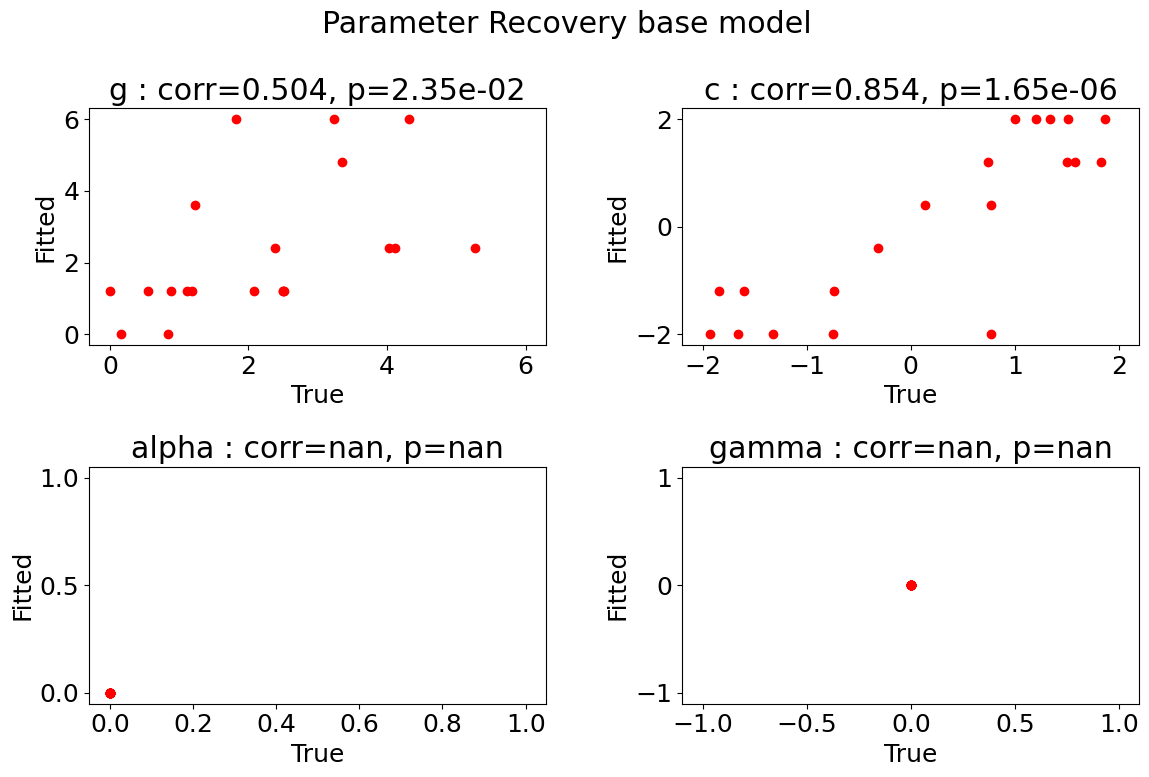

In [ ]:
# plot the true to fitted parameters correlation for base model
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust the figsize as needed
axs = axs.ravel()
fig.suptitle('Parameter Recovery base model')

# set some margine to better see edge points
margin = 0.05

plot_true_fitted_correlation(to_recover_g, fitted_g_log_base, g_values, margin, axs[0])
axs[0].set_title(f'g : corr={corr_values_base.loc["g", "correlation"]}, p={corr_values_base.loc["g", "p-value"]}')

plot_true_fitted_correlation(to_recover_c, fitted_c_log_base, c_values, margin, axs[1])
axs[1].set_title(f'c : corr={corr_values_base.loc["c", "correlation"]}, p={corr_values_base.loc["c", "p-value"]}')

plot_true_fitted_correlation(np.zeros(num_true_param_set), fitted_alpha_log_base, alpha_values, margin, axs[2])
axs[2].set_title(f'alpha : corr={corr_values_base.loc["alpha", "correlation"]}, p={corr_values_base.loc["alpha", "p-value"]}')

plot_true_fitted_correlation(np.zeros(num_true_param_set), fitted_gamma_log_base, gamma_values,margin, axs[3])
axs[3].set_title(f'gamma : corr={corr_values_base.loc["gamma", "correlation"]}, p={corr_values_base.loc["gamma", "p-value"]}')

plt.tight_layout()
plt.show()

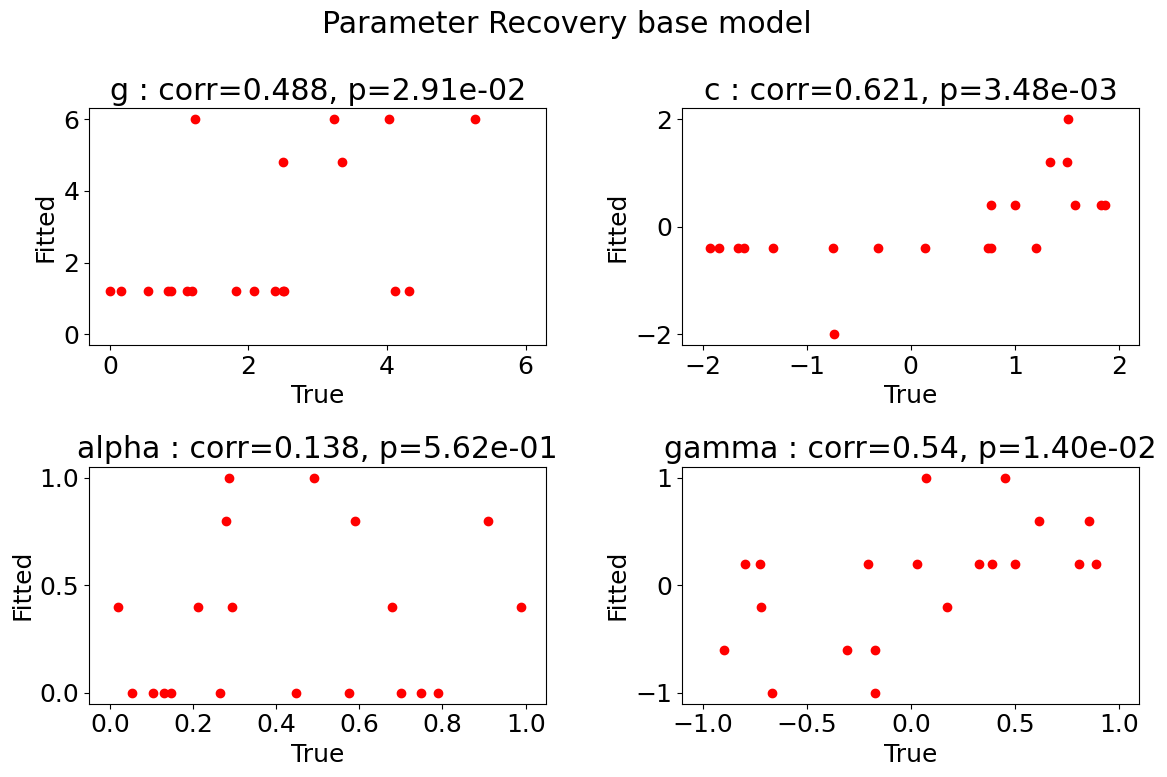

In [ ]:
# plot the true to fitted parameters correlation for perseverence model
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust the figsize as needed
axs = axs.ravel()
fig.suptitle('Parameter Recovery base model')

# set some margine to better see edge points
margin = 0.05

plot_true_fitted_correlation(to_recover_g, fitted_g_log_P, g_values, margin, axs[0])
axs[0].set_title(f'g : corr={corr_values_P.loc["g", "correlation"]}, p={corr_values_P.loc["g", "p-value"]}')

plot_true_fitted_correlation(to_recover_c, fitted_c_log_P, c_values, margin, axs[1])
axs[1].set_title(f'c : corr={corr_values_P.loc["c", "correlation"]}, p={corr_values_P.loc["c", "p-value"]}')

plot_true_fitted_correlation(to_recover_alpha, fitted_alpha_log_P, alpha_values, margin, axs[2])
axs[2].set_title(f'alpha : corr={corr_values_P.loc["alpha", "correlation"]}, p={corr_values_P.loc["alpha", "p-value"]}')

plot_true_fitted_correlation(to_recover_gamma, fitted_gamma_log_P, gamma_values, margin, axs[3])
axs[3].set_title(f'gamma : corr={corr_values_P.loc["gamma", "correlation"]}, p={corr_values_P.loc["gamma", "p-value"]}')

plt.tight_layout()
plt.show()

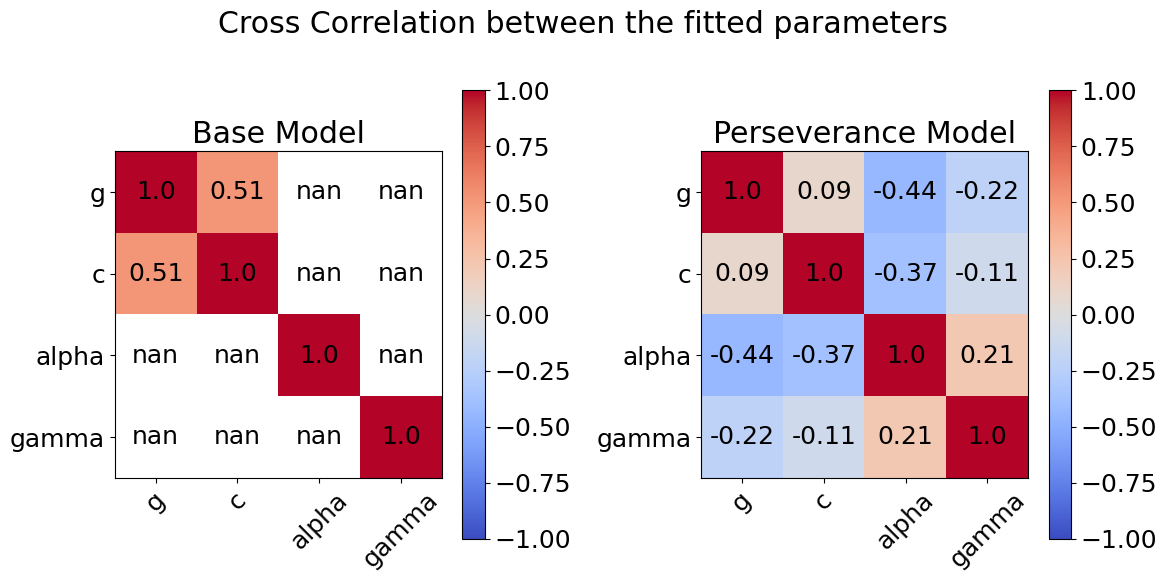

In [ ]:
# plot cross correlation between the fitted parameters for both models
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figsize as needed
fig.suptitle('Cross Correlation between the fitted parameters')

# base model
im_base = axes[0].imshow(cross_corr_base, cmap='coolwarm', vmin=-1, vmax=1)
# show correlation values
for i in range(4):
    for j in range(4):
        axes[0].text(j, i, cross_corr_base.iloc[i, j].round(2), ha='center', va='center', color='black')
axes[0].set_xticks(np.arange(4))
axes[0].set_yticks(np.arange(4))
axes[0].set_xticklabels(param_names, rotation=45)
axes[0].set_yticklabels(param_names)
axes[0].set_title('Base Model')
plt.colorbar(im_base, ax=axes[0])

# perseverence model
im_P = axes[1].imshow(cross_corr_P, cmap='coolwarm', vmin=-1, vmax=1)
for i in range(4):
    for j in range(4):
        axes[1].text(j, i, cross_corr_P.iloc[i, j].round(2), ha='center', va='center', color='black')
axes[1].set_xticks(np.arange(4))
axes[1].set_yticks(np.arange(4))
axes[1].set_xticklabels(param_names, rotation=45)
axes[1].set_yticklabels(param_names)
axes[1].set_title('Perseverance Model')
plt.colorbar(im_P, ax=axes[1])

plt.tight_layout()
plt.show()

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [33]:
# YOUR MODEL RECOVERY CODE GOES HERE

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [34]:
import os
import glob
import random

# Step 1: Define the folder path containing the CSV files
folder_path = r"C:\Uni\WiSe 2425\Modeling in NS\Project\Clean data folder"  # Replace with the actual path to your folder

# Debugging: Print the folder path to confirm it's correct
print(f"Folder path being used: {folder_path}")

# Debugging: List all files in the folder to check if CSV files exist
print("All files in the folder:")
for file_name in os.listdir(folder_path):
    print(file_name)

# Step 2: Use glob to find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Step 3: Print the list of CSV files
print("\nList of CSV files:")
for csv_file in csv_files:
    print(csv_file)

# If the list is still empty, check the file extensions or folder structure
if not csv_files:
    print("\nNo CSV files found. Please check the folder path and file extensions.")

Folder path being used: C:\Uni\WiSe 2425\Modeling in NS\Project\Clean data folder
All files in the folder:


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Uni\\WiSe 2425\\Modeling in NS\\Project\\Clean data folder'

In [ ]:
# Define the folder path containing the CSV files
folder_path = r"C:\Uni\WiSe 2425\Modeling in NS\Project\Clean data folder"  # Replace with the actual path to your folder

# Use glob to find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

# Debugging: Print the list of CSV files
print("List of CSV files:")
for csv_file in csv_files:
    print(csv_file)

# If no CSV files are found, print a warning
if not csv_files:
    print("\nNo CSV files found. Please check the folder path and file extensions.")

# Parameter Fitting Setup
seed = 40
random.seed(seed)

# Search space over parameters
num_samples = 3
min_g, max_g = 0, 8
min_c, max_c = -2, 2
min_alpha, max_alpha = 0, 4
min_gamma, max_gamma = -2, 2

c_values = np.linspace(min_c, max_c, num_samples)
g_values = np.linspace(min_g, max_g, num_samples)
alpha_values = np.linspace(min_alpha, max_alpha, num_samples)
gamma_values = np.linspace(min_gamma, max_gamma, num_samples)

# Experiment parameters
num_trials = 100
T = 2
sigma = 0.2
x_0 = [0.5, 0.5, 0]

# Initialize a dictionary to store the best-fitting parameters for each participant
participant_results = {}

# Loop through each CSV file (each participant's data)
for idx, csv_file in enumerate(csv_files):
    print(f"\nProcessing participant {idx + 1}: {csv_file}")

    # Load the participant's data from the CSV file
    data_cleaned = pd.read_csv(csv_file)


# run parameter fitting and get the LL landscape values and the best fitted parameters
    # Fit the full model (all parameters free to vary)
    best_g_P, best_c_P, best_alpha_P, best_gamma_P, best_LL_P, LL_matrix_P = param_fit_grid_search_parallel(
        data_cleaned, T, x_0, g_values, c_values, alpha_values, gamma_values, sigma)

    # Fit the base model (alpha and gamma fixed to 0)
    best_g_base, best_c_base, best_alpha_base, best_gamma_base, best_LL_base, LL_matrix_base = param_fit_grid_search_parallel(
        data_cleaned, T, x_0, g_values, c_values, np.zeros(1), np.zeros(1), sigma)


    # Store the results in the dictionary
    participant_results[f"participant_{idx + 1}"] = {
        "best_LL_base": best_LL_base,
        "best_c_base": best_c_base,
        "best_g_base": best_g_base,
        "best_alpha_base": 0,  # alpha is fixed to 0 in the base model
        "best_gamma_base": 0,  # gamma is fixed to 0 in the base model
        "best_LL_P": best_LL_P,
        "best_c_P": best_c_P,
        "best_g_P": best_g_P,
        "best_alpha_P": best_alpha_P,
        "best_gamma_P": best_gamma_P,
    }

    # Print the results for the current participant
    print(f"Participant {idx + 1} Results:")
    print(f"Base Model: LL = {best_LL_base}, c = {best_c_base}, g = {best_g_base}, alpha = 0, gamma = 0")
    print(f"Full Model: LL = {best_LL_P}, c = {best_c_P}, g = {best_g_P}, alpha = {best_alpha_P}, gamma = {best_gamma_P}")

# Print the final dictionary of results
print("\nFinal Participant Results:")
print(participant_results)

IndentationError: unexpected indent (4148378987.py, line 52)